# 80_ra271.352_dec-29.642_MAXIJ1803

In [1]:
from pathlib import Path
import numpy as np
import arviz as az
import graphviz as gv
import utility_functions as ufn
import importlib
import seaborn as sns

importlib.reload(ufn)
az.style.use("arviz-white")

RANDOM_SEED = 2023-11-21
rng = np.random.default_rng(RANDOM_SEED)

OVERWRITE_TRACES = False

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.10.2
Running on PyMC v5.10.2


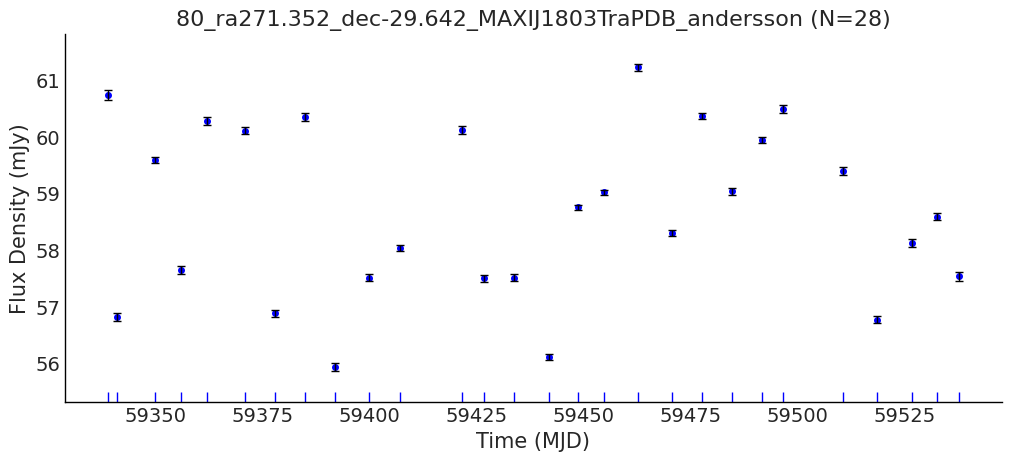

In [2]:
# File paths to CSVs of flux density observations.
csv_paths_list = sorted(list(Path('data_raw').iterdir()))
csv_path = csv_paths_list[4]
ufn.plot_lc(csv_path, show_title=True, save_plot=False);

## SE GP + Periodic GP

$$ Y = f(x) + \varepsilon$$

$$\varepsilon \sim \mathcal{N}(0, \Sigma_\varepsilon)$$

$$\Sigma_\varepsilon = \boldsymbol{e}^2 \boldsymbol{I}$$

$$f(t) \sim \mathcal{GP}(\boldsymbol{0}, k_\textrm{SE}(\tau)) + \mathcal{GP}(\boldsymbol{0}, k_\textrm{P}(\tau))$$

$$k_\textrm{SE}(\tau) = \eta_\textrm{SE}\exp\left\{ - \frac{1}{2\ell_\textrm{SE}^2}\tau^2\right\}$$

$$\quad k_\textrm{P}(\tau) = \eta_\textrm{P} \exp \left\{ -\frac{1}{2\ell^2_\textrm{P}}\sin^2 \left(\pi\frac{\tau}{T}\right)\right\}$$

$$\ell_\textrm{SE} \sim \textrm{min. gap}(t) + \textrm{InvGamma}\left(\alpha = 3, \beta = \frac{1}{2} \times \textrm{range}(t)\right)$$

$$\ell_\textrm{P} \sim \textrm{min. gap}(t) + \textrm{InvGamma}\left(\alpha = 3, \beta= \frac{1}{2} \times \textrm{range}(t)\right)$$

$$\eta_\textrm{SE} \sim \mathcal{N}^+(0, 1)$$

$$\eta_\textrm{P} \sim \mathcal{N}^+(0, 1)$$

$$T \sim \mathcal{U}\left[4 \times \textrm{min. gap}(t), \frac{1}{4} \times \textrm{range}(t)\right]$$

Sampling: [T, ell_Per, ell_SE, eta_Per, eta_SE, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta_SE, eta_Per, ell_SE, ell_Per, T]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 41 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [f_star, f_star_Per, f_star_SE]


/home/scf/.venv/lib/python3.10/site-packages/scipy/stats/_multivariate.py:758: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


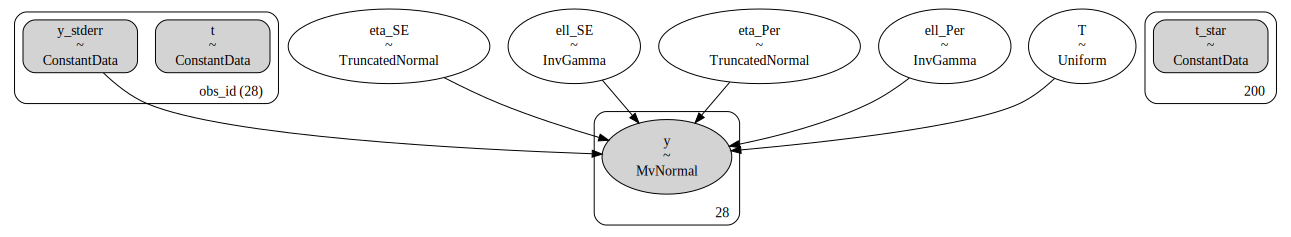

In [3]:
gpSE_gpPer_trace_path = Path(f"traces/{csv_path.stem}_gpSE_gpPer_idata.nc")
gpSE_gpPer_dag_path = Path(f'dags/{csv_path.stem}_gpSE_gpPer_dag.dot')

if gpSE_gpPer_trace_path.is_file() and not OVERWRITE_TRACES:
    gpSE_gpPer_trace = az.from_netcdf(gpSE_gpPer_trace_path)
    gpSE_gpPer_dag = gv.Source.from_file(gpSE_gpPer_dag_path)
else:
    gpSE_gpPer_trace, gpSE_gpPer_dag = ufn.fit_gpSE_gpPer(csv_path, standardise_y=True, rng_seed=rng);
    az.to_netcdf(gpSE_gpPer_trace, gpSE_gpPer_trace_path)
    with open(gpSE_gpPer_dag_path, 'w') as writehandle:
        writehandle.write(gpSE_gpPer_dag.source)

gv.Source(gpSE_gpPer_dag.source)

In [4]:
variable_names = ["ell_SE", "ell_Per", "eta_SE", "eta_Per", "T"]
ufn.print_post_summary(gpSE_gpPer_trace, variable_names)

,median,mad,eti_16%,eti_84%,mcse_median,ess_median,ess_tail,r_hat,mean,sd
ell_SE,3.154558,0.204438,2.874997,3.475946,0.007697,3183.068508,2972.179487,1.001299,3.168240,0.301962
ell_Per,36.670834,13.888039,21.207258,71.067655,0.396299,3831.218907,2269.623158,1.000877,48.999336,45.340522
eta_SE,2.649839,0.352839,2.191455,3.232550,0.011826,3325.031620,2857.700554,1.001184,2.699935,0.530147
eta_Per,0.489560,0.323363,0.127207,1.169798,0.011625,2724.037644,1616.073797,1.000051,0.628383,0.534966
T,29.318556,10.446572,15.279165,43.438877,0.305147,4023.087155,2245.112145,1.001417,29.293032,11.901208


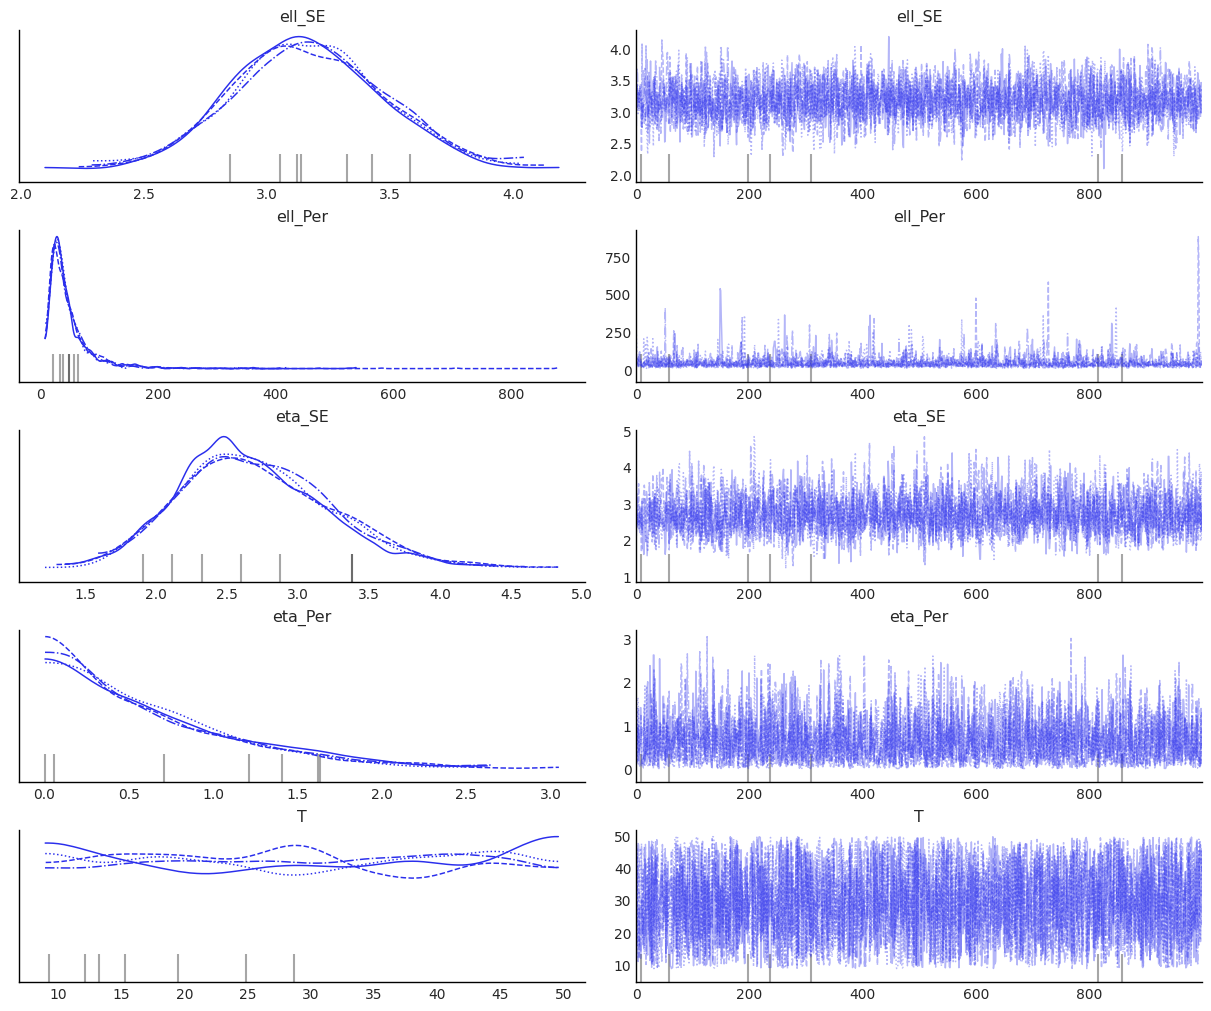

In [5]:
ufn.plot_traces(gpSE_gpPer_trace, variable_names);

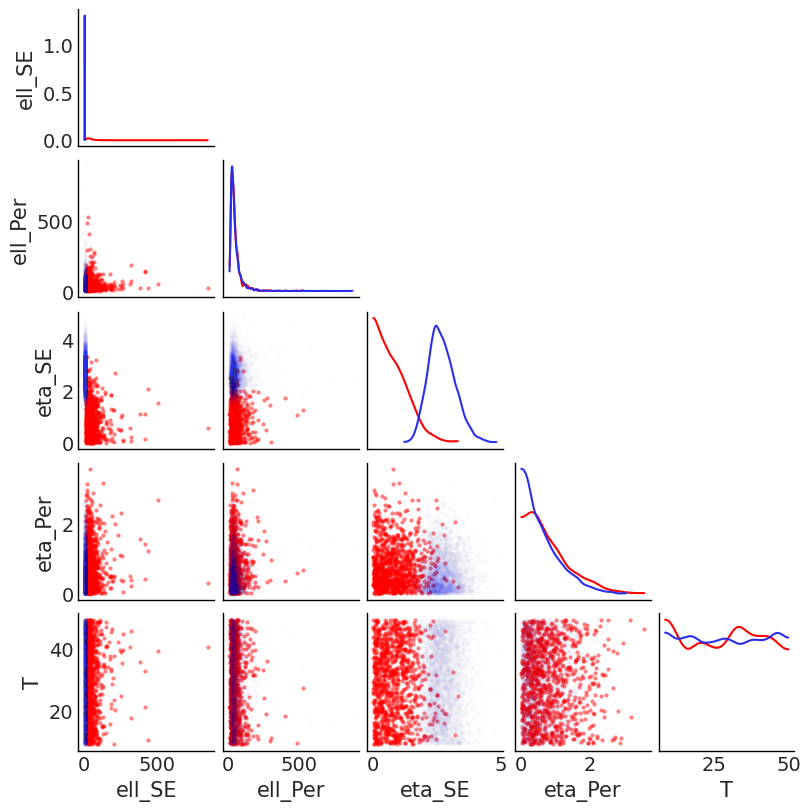

In [6]:
ufn.plot_priorpost_cnr(gpSE_gpPer_trace, variable_names)

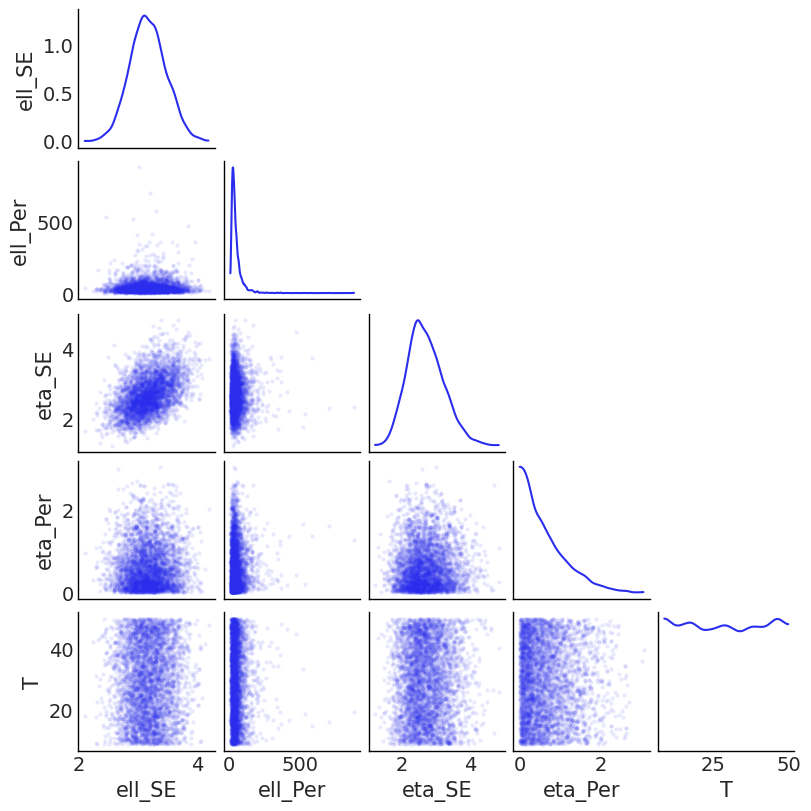

In [7]:
ufn.plot_post_cnr(gpSE_gpPer_trace, variable_names=variable_names)

array([46.63480504, 44.59470942, 23.17370543,  9.91308392, 17.05341858,
       29.29399229, 26.23384886, 31.3340879 , 36.43432695, 11.95317954,
       15.01332296, 19.0935142 , 39.49447037, 41.53456599])

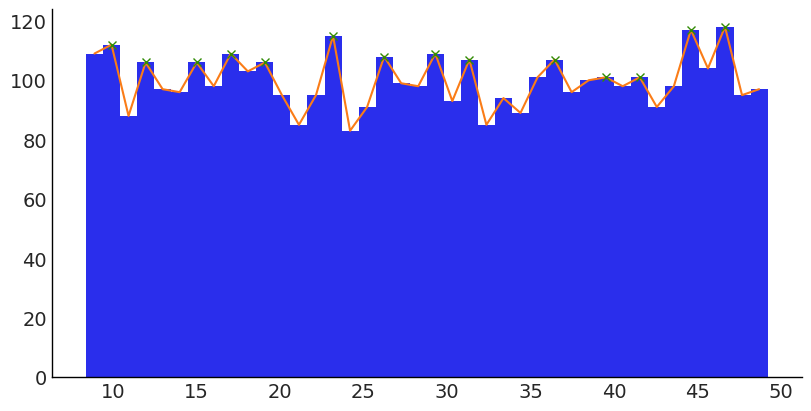

In [8]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
n, bins, patches = ax.hist(az.extract(gpSE_gpPer_trace, group="posterior", var_names="T"), align="left", bins=40);

peaks, _ = find_peaks(n, height=100)
ax.plot(bins[0:-1],n)
ax.plot(bins[peaks], n[peaks], "x")
T_modes = bins[peaks][np.argsort(-n[peaks])] # peak locations, descending order by height
T_modes

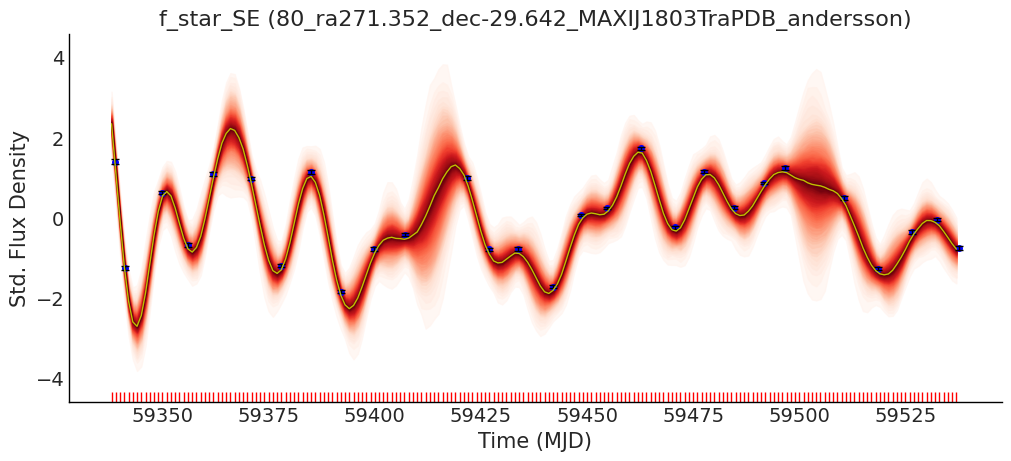

In [9]:
ufn.plot_postpred_samples(gpSE_gpPer_trace, "f_star_SE", show_title=True, save_plot=False)

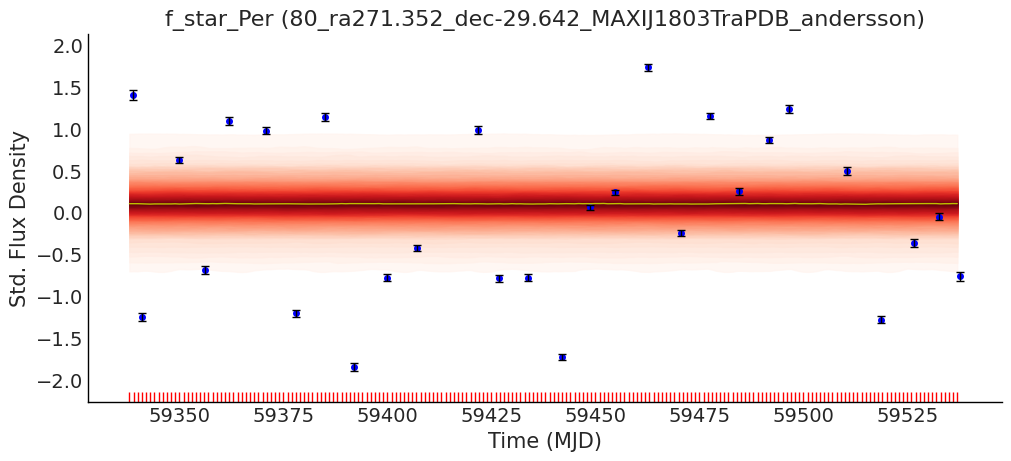

In [10]:
ufn.plot_postpred_samples(gpSE_gpPer_trace, "f_star_Per", show_title=True, save_plot=False)

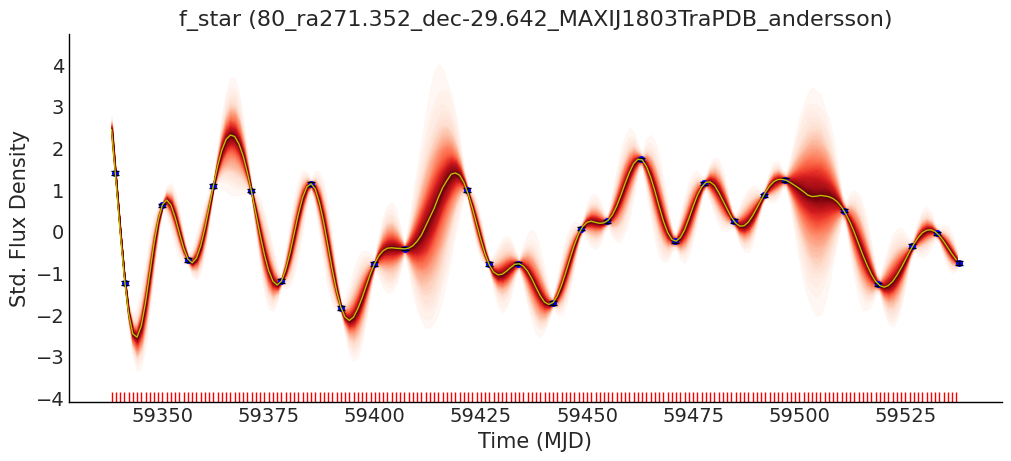

In [11]:
ufn.plot_postpred_samples(gpSE_gpPer_trace, "f_star", show_title=True, save_plot=False)

/home/scf/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 28, using nperseg = 28
  warnings.warn('nperseg = {0:d} is greater than input length '


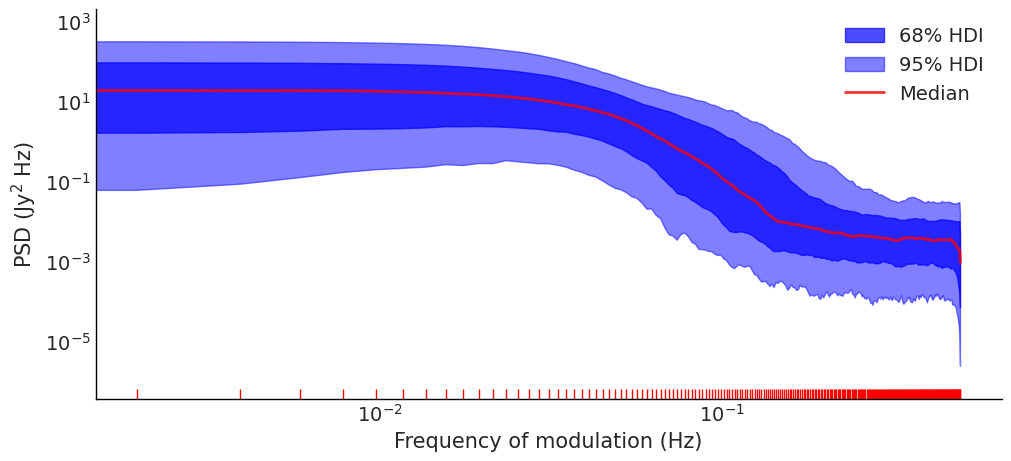

In [12]:
ufn.plot_welch_psd(gpSE_gpPer_trace, group="prior_predictive", variable_name="y")
this_xlim = plt.xlim()
#plt.savefig(f"figures/{csv_path.stem}_priorpred_welchpsd.jpg", dpi=300, bbox_inches='tight')

/home/scf/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '


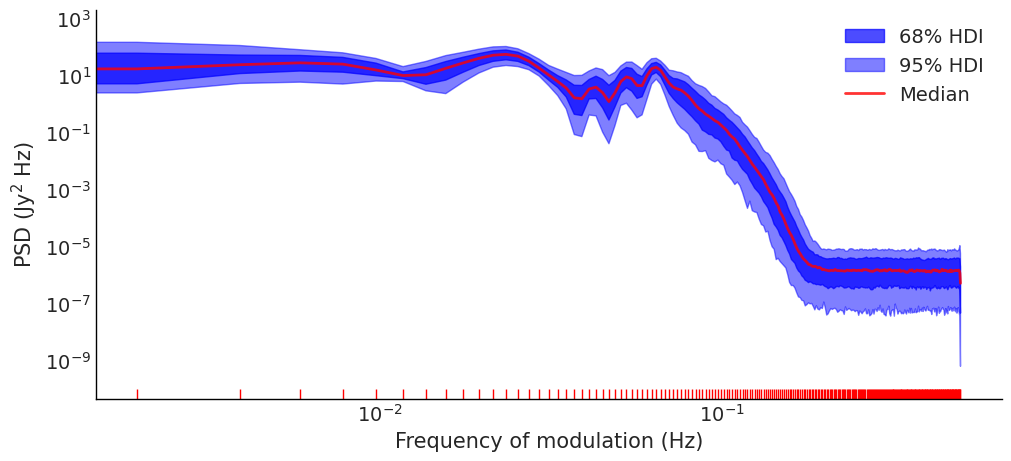

In [13]:
ufn.plot_welch_psd(gpSE_gpPer_trace, group="posterior_predictive", variable_name="f_star_SE");
#plt.savefig(f"figures/{csv_path.stem}_postpred_welchpsd_fstarSE.jpg", dpi=300, bbox_inches='tight')

/home/scf/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '


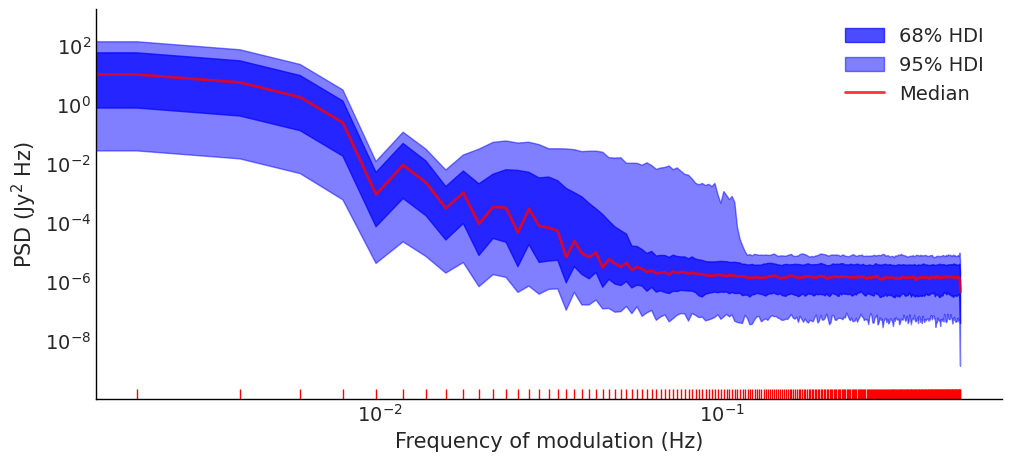

In [14]:
ufn.plot_welch_psd(gpSE_gpPer_trace, variable_name="f_star_Per");
#plt.savefig(f"figures/{csv_path.stem}_andersson_postpred_welchpsd_fstarPer.jpg", dpi=300, bbox_inches='tight')

/home/scf/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '


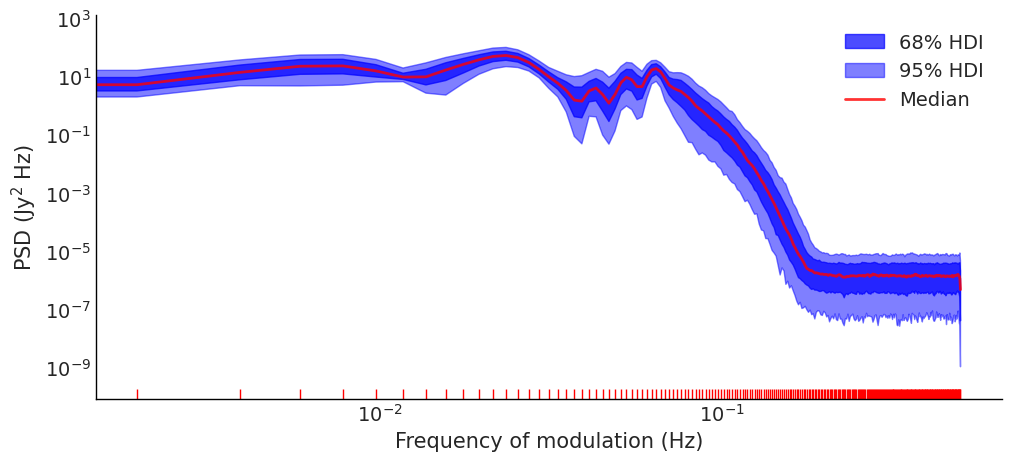

In [15]:
ufn.plot_welch_psd(gpSE_gpPer_trace, group="posterior_predictive", variable_name="f_star")
#plt.savefig(f"figures/{csv_path.stem}_andersson_postpred_welchpsd_fstar.jpg", dpi=300, bbox_inches='tight')

/home/scf/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/scf/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/scf/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '


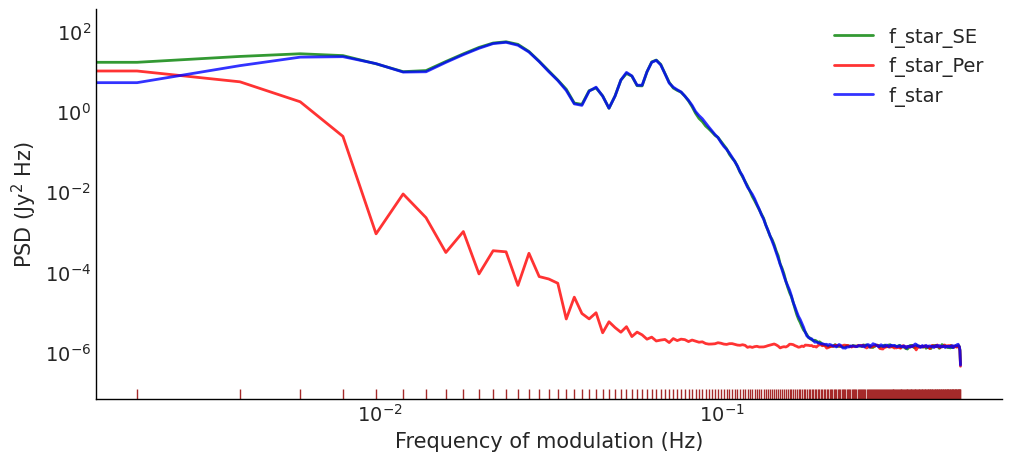

In [16]:
ufn.plot_welch_psds(gpSE_gpPer_trace)
#plt.savefig(f"figures/{csv_path.stem}_postpred_welchpsds.jpg", dpi=300, bbox_inches='tight')

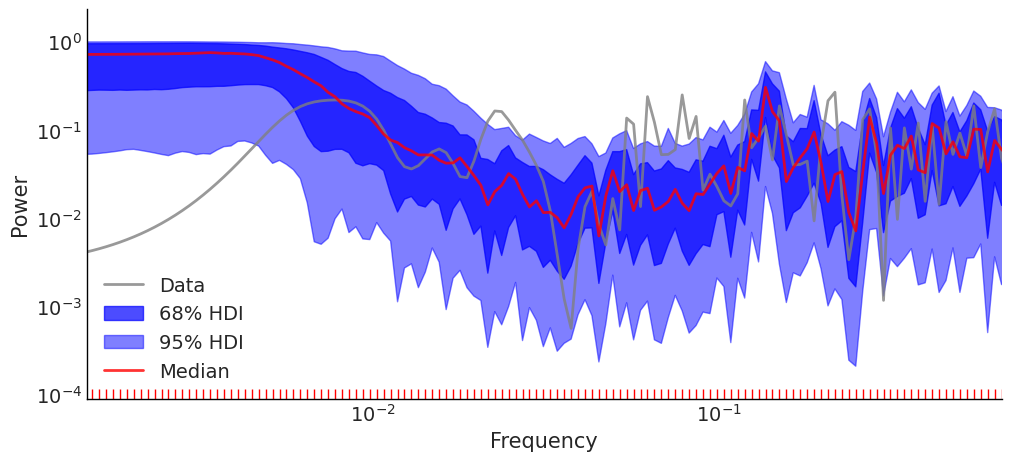

In [17]:
ufn.plot_lsp(gpSE_gpPer_trace, "prior_predictive", "y")
plt.xlim(this_xlim);
#plt.savefig(f"figures/{csv_path.stem}_priorpred_lsp.jpg", dpi=300, bbox_inches='tight')

/home/scf/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/scf/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/scf/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/scf/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


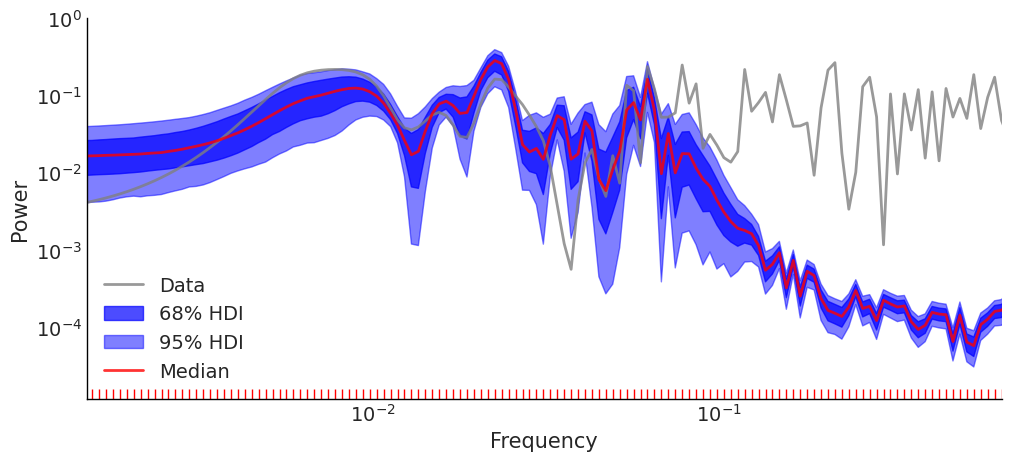

In [18]:
ufn.plot_lsp(gpSE_gpPer_trace, group="posterior_predictive", variable_name="f_star")
plt.xlim(this_xlim);
#plt.savefig(f"figures/{csv_path.stem}_postpred_lsp_fstar.jpg", dpi=300, bbox_inches='tight')

/home/scf/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/scf/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/scf/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/scf/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


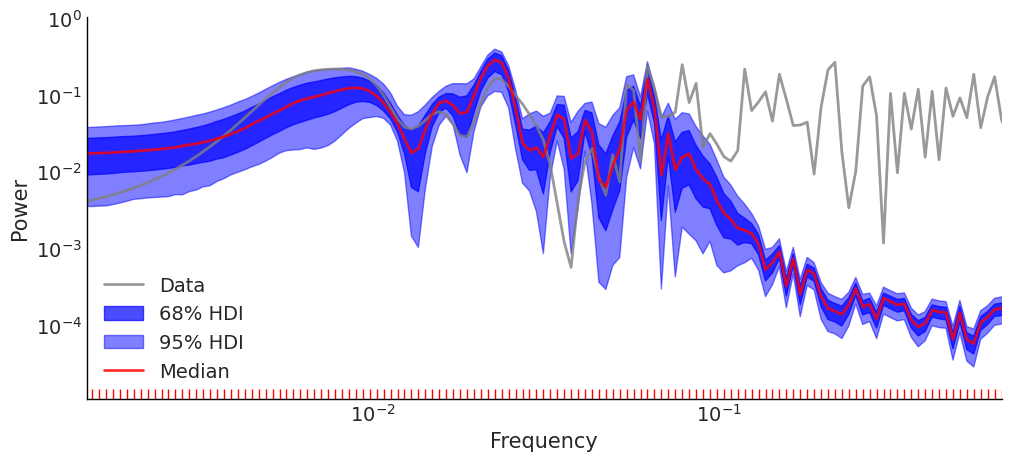

In [19]:
ufn.plot_lsp(gpSE_gpPer_trace, group="posterior_predictive", variable_name="f_star_SE")
plt.xlim(this_xlim);
#plt.savefig(f"figures/{csv_path.stem}_postpred_lsp_fstarSE.jpg", dpi=300, bbox_inches='tight')

/home/scf/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/scf/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/scf/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/scf/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


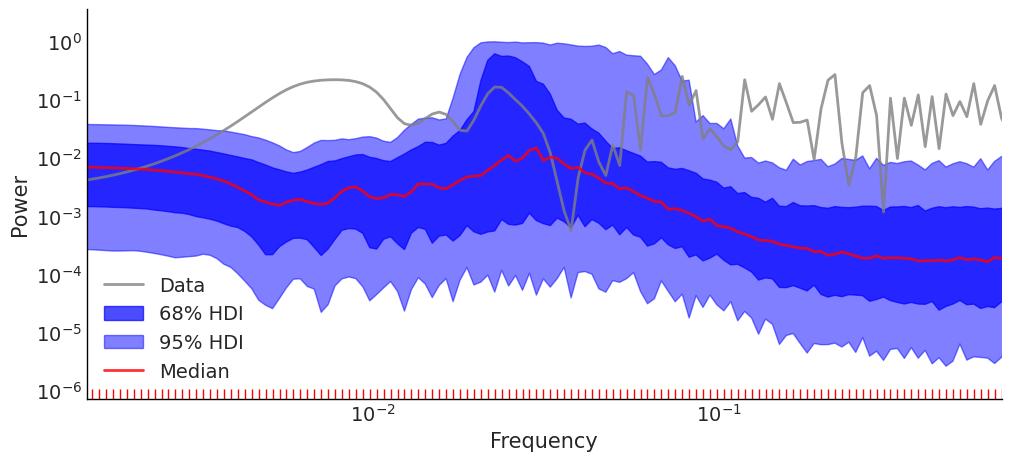

In [20]:
ufn.plot_lsp(gpSE_gpPer_trace, group="posterior_predictive", variable_name="f_star_Per")
plt.xlim(this_xlim);
#plt.savefig(f"figures/{csv_path.stem}_postpred_lsp_fstarPer.jpg", dpi=300, bbox_inches='tight')

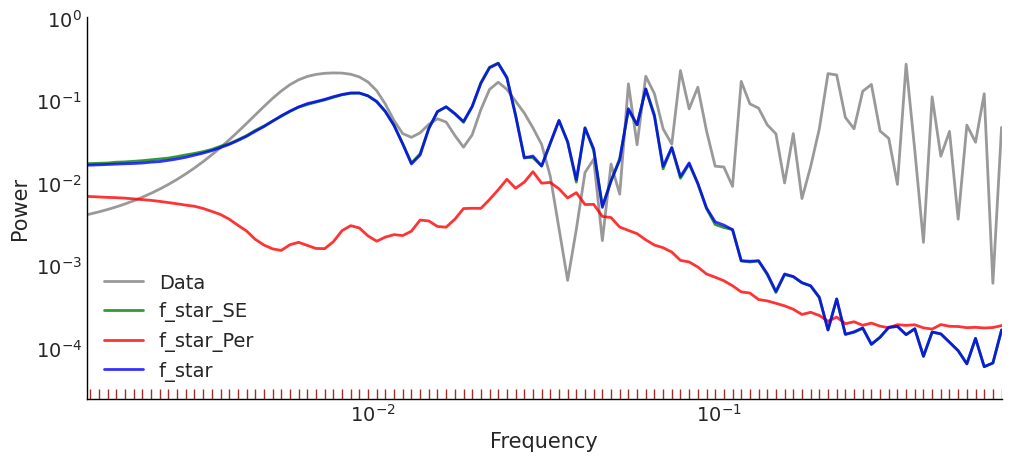

In [21]:
ufn.plot_lsps(gpSE_gpPer_trace, group="posterior_predictive")
plt.xlim(this_xlim);
#plt.savefig(f"figures/{csv_path.stem}_postpred_lsps.jpg", dpi=300, bbox_inches='tight')